# NeuralNet - From Scratch

#### Woah, a whole neural network, from scratch!? Crazy!! Let's see how it's done.

First of all, we import a few things:

In [96]:
import numpy as np
from numpy import random, array, exp, dot
from numpy.random import seed

In Python, NumPy is a fantastic library for working with the kinds of numbers and functions we need to do machine learning.

In [97]:
import matplotlib
import matplotlib.pyplot as plt

MatPlotLib gives us access to a nice library of plotting tools.
PyPlot gives us a snazzy method of graphically representing our data.

In [98]:
import sklearn
from sklearn import datasets, linear_model

SkLearn is one of the leading machine learning libraries. These imports give us access to a whole bunch of data to train against (datasets), as well as a linear_model to act as the starting function for the logistic regression we are going to be doing later

In [99]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0) #1
X, y = datasets.make_moons(200, noise=0.20)         #2
num_examples = len(X)                               #3
nn_input_dim = 2                                    #4
nn_output_dim = 2                                   #5

1. Initializing the size of our plot graph
2. Initializing our collection of inputs (X, y)
3. Counting the number of training examples we have
4. Setting the dimensionality of our input layer
5. Setting the dimensionality of our output layer

In [100]:
# Arbitrary, custom values
seed(0)
epsilon = 0.0001 # Learning rate for gradient descent
reg_lambda = 0.0001 # Regularization strength

We set our seed value to 0, so that we get some consistency with our random numbers; this helps our network actually learn.
We then set our gradient descent rate to a chosen value of 0.01 and the lambda value for regularization to also be 0.01.
We want these numbers to be small because they are what influence change in the neural network, and if we have these number being large, the network would never be very accurate in it's predictions.

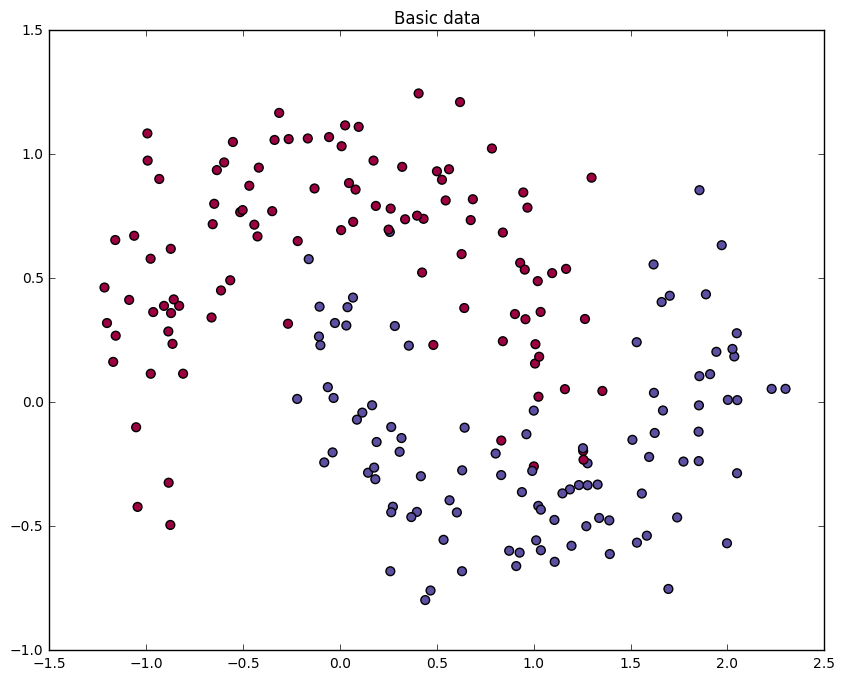

In [101]:
#%matplotlib inline
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.title("Basic data")
plt.show()

In [102]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

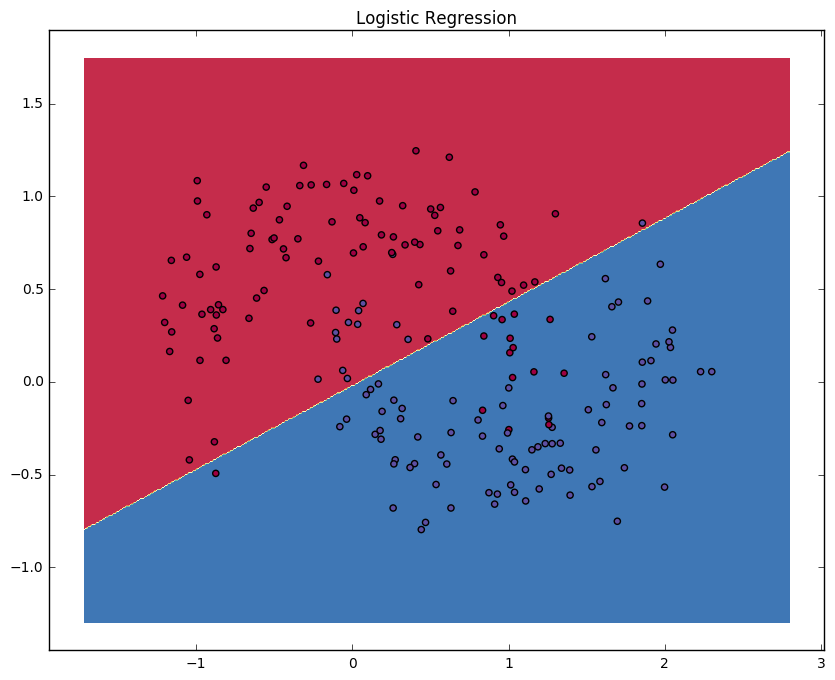

In [103]:
clf = linear_model.LogisticRegressionCV()
clf.fit(X, y)
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")
plt.show()

In [104]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [105]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):

    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}

    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2

        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 10000 == 0:
          print "Loss after iteration %i: %f" %(i, calculate_loss(model))
        elif i == 1: print "Loading..."

    return model

Loss after iteration 0: 0.803712
Loading...
Loss after iteration 10000: 0.143749
Loss after iteration 20000: 0.100792
Loss after iteration 30000: 0.092376
Loss after iteration 40000: 0.088528
Loss after iteration 50000: 0.086127
Loss after iteration 60000: 0.084500
Loss after iteration 70000: 0.083254
Loss after iteration 80000: 0.082211
Loss after iteration 90000: 0.081285


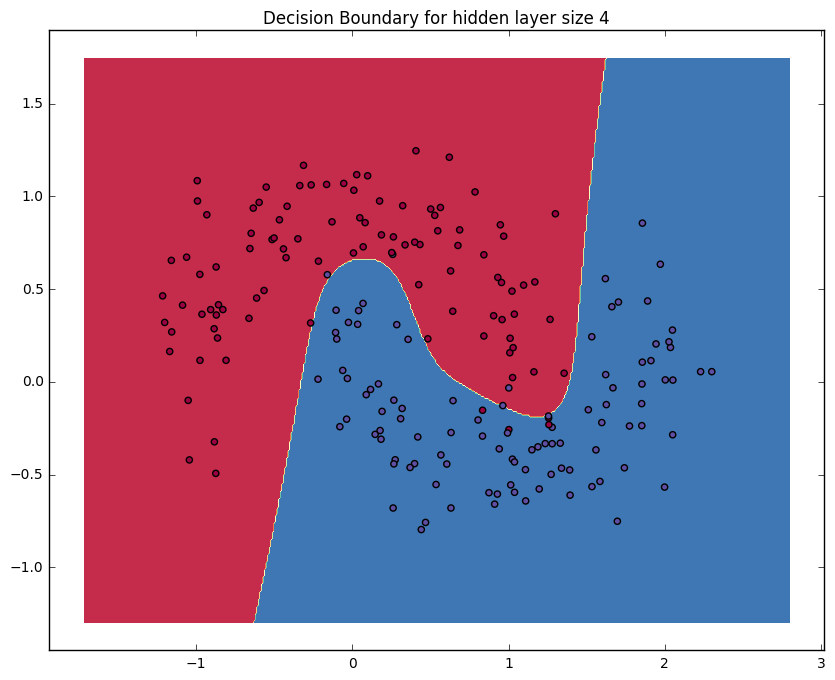

Success


In [107]:
endmodel = build_model(5, num_passes=100000, print_loss=True)

plot_decision_boundary(lambda x: predict(endmodel, x))
plt.title("Decision Boundary for hidden layer size 4")
plt.show()

# train_lrc()
print "Success"
# print generate_dataset()